# Ho and Lee model

In this post, I discuss how to implement Ho Lee short term interest rate model.

The short rate is assumed to satisfy the following stochastic diﬀerential equation

$$ dr_t = \theta(t)dt + \sigma dW_t  $$

The price of a zero coupon bond is

\begin{equation}
P(t,T) = e^{A(t,T) -(T-t)r_0}
\end{equation}

where $r_0$ is the current level of (short term) interest rates

<br>
\begin{equation}
A(t, T) = -\int_t^{T}\left(T-s\right)\theta_sds+\frac{1}{2}\int_t^{T}\left(T-s\right)^2\sigma^2ds\end{equation}
<br>


\begin{equation}
\theta(t) = \frac{{\partial}f(0,t)}{{\partial}t} + \sigma^2t
\end{equation}

$\theta(t)$ is the drift rate that matches the current term structure of interest rates 

Given the formula for the zero coupon bond, it is also possible to write the yield for a maturity $\tau$ as

<br>
\begin{equation}
Y(t,t+\tau) = -\frac{A(t,t+\tau)}{\tau} + r_t
\end{equation}
<br>

#### Loading python libraries

In [1]:
import numpy as np
import numpy.random as npr
from scipy import integrate
import scipy.integrate as sciIntegr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.interpolate import splrep, splev

In [2]:
from Bond import *

In [3]:
dataframe    =  pd.DataFrame.from_csv('Strips.csv', index_col=None)
print (dataframe.shape)
dataframe.head(10)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


(78, 3)


,Time,Zeros,Prices
0,0.003968,0.011107,0.999956
1,0.347945,0.015111,0.994756
2,0.436447,0.016121,0.992989
3,0.524948,0.017110,0.991058
4,0.613450,0.018079,0.988971
5,0.701951,0.019027,0.986733
6,0.790452,0.019956,0.984350
7,0.878954,0.020864,0.981828
8,0.967455,0.021753,0.979174
9,1.055957,0.022623,0.976394


In [4]:
class HoLee(Bond):
    def __init__(self, ZCB, times, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
    
        self.dt     = 0.00001
        self._ZCB   = ZCB
        self._times = times
        
        self.ret= splrep(self._times, -np.log(self._ZCB)/ self._times)                
        
    def fitting(self,x):
        return splev(x, self.ret)
    
    def dfitt(self,x):
        return splev(x, self.ret, der=1)
    
    def ForwardRate(self, time):                
        r        = self.SpotRate(time)
        ##r        = self.fitting(time)                        
        dr_dt    = self.dfitt(time)
        
        fwd_rate = r + time * dr_dt                    
        return fwd_rate
    
    def SpotRate(self, time):            
        return self.fitting(time)        
    
    def PrepareThetas(self):
        Timeline      = np.linspace(Maturities[0], Maturities[-1],100)
        Thetarates    = [self.Thetat(t) for t in Timeline]
        self.Thetarates = splrep(Timeline, Thetarates)
        
    def A(self, t, T):                    
               
        def integrand1(time):
            theta = splev(time, self.Thetarates)
            return theta * (T - time)
            
        def integrand2(time):
            return ((T-time)**2)*self.sigma**2
        
        val1 = integrate.quad(integrand1, t, T)[0]
        val2 = integrate.quad(integrand2, t, T)[0]
        return -val1 + 0.5*val2
        
    def Yield(self, t, T, rate):
        res    = np.exp(self.A(t, T)  - (T-t)*rate)
        return -np.log(res)/(T-t)
        
    def Thetat(self, time):  
        up       = np.max(time + self.dt,0)
        down     = np.max(time - self.dt,0)

        df       = self.ForwardRate(down) - self.ForwardRate(up)     
        df_dt    = -df/(2*self.dt)
        
        return df_dt + self.sigma**2*time
        
    def ZCB_Forward_Integral(self,t, T):                                         
        val = integrate.quad(self.ForwardRate, t, T)[0]
        return np.exp(-val)    
    
    def B(self, t, T):
        return (T-t)*self.r0
    
    def Exact_zcb(self, t, T):                                
        return np.exp(self.A(t, T)  - self.B(t, T))
    
    def Euler(self, M, I, tau):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # tau is the maturity        
        dt = tau / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, tau, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = xh[t - 1] + self.Thetat(self.times[t-1]) * dt + \
                  self.sigma * np.sqrt(dt) * npr.standard_normal(I)
        self.rates = xh
        
        return 0
    
    def ExpectedRate(self,t, T):
               
        def integrand(time):
            theta = splev(time, self.Thetarates)
            return theta
                    
        val = self.r0 + integrate.quad(integrand, t, T)[0]
        return val

In [5]:
Maturities = np.asarray(dataframe.Time)
Prices     = np.asarray(dataframe.Prices)
rate0      = -np.log(Prices[0])/Maturities[0]
print(rate0)

0.011106892675553953


In [6]:
r0    = rate0 # current level of rates
kappa = ""    # speed of convergence - Not required in Ho Lee Model
theta = ""    # long term rate - Not required in Ho Lee Model
sigma = 0.021 # vol    

In [7]:
# create an instance of the object HoLee and calculate the theta(t)
lohee = HoLee(Prices,Maturities, theta, kappa, sigma,rate0)
lohee.PrepareThetas()

use some functions and check all is ok

In [8]:
print(-np.log(lohee.Exact_zcb(0,1)))
print(lohee.Yield(0,1,rate0))
print(-np.log(lohee.ZCB_Forward_Integral(0,1)))
print(dataframe.Zeros[9])
print(dataframe.Zeros[8])

0.02212040403810032
0.02212040403810032
0.02207551892796123
0.022623262999999998
0.021753417999999997


In [9]:
# The forward rate for the period t = 1, t= 2 is 
print(-np.log(lohee.ZCB_Forward_Integral(1,2)))

0.039447916443125924


In [10]:
# Caculate the future short term rate in one year
print(lohee.ExpectedRate(0,1))

0.032197331370602274


In [11]:
# and from the expected short term rate, we calculate the one year yield 
print(lohee.Yield(1,2,lohee.ExpectedRate(0,1)))

0.039933034874662036


In [12]:
# we can also use the Ho Lee ZCB formula to calculate the forward rate for the period t = 1, t= 2 
print(lohee.Exact_zcb(0,2)/lohee.Exact_zcb(0,1))
print(lohee.ZCB_Forward_Integral(1,2))

0.9612776103659012
0.9613200216527579


### Plot spot, forward rates and $\theta(t)$

In [13]:
Timeline  = np.linspace(Maturities[0], Maturities[-1],100)
Fwdrates  = [lohee.ForwardRate(t) for t in Timeline]
Spotrates = [lohee.SpotRate(t) for t in Timeline]
Thetarates= [lohee.Thetat(t) for t in Timeline]
LoheePrices=[lohee.Exact_zcb(0, t) for t in Timeline]

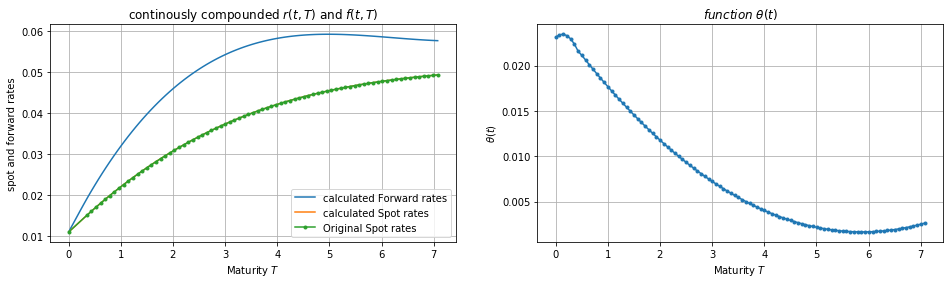

In [14]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(Timeline, Fwdrates, label ='calculated Forward rates')
plt.plot(Timeline, Spotrates, label='calculated Spot rates')
plt.plot(Maturities, -np.log(Prices)/Maturities, marker='.', label='Original Spot rates')
plt.xlabel(r'Maturity $T$ ')
plt.title(r'continously compounded $r(t,T)$ and $f(t,T)$')
plt.grid(True)
plt.legend()
plt.ylabel('spot and forward rates')

plt.subplot(122)
plt.plot(Timeline, Thetarates, marker='.',label =r'$\theta(t)$')
plt.xlabel(r'Maturity $T$') 
plt.title(r'$function$ $\theta(t)$')
plt.grid(True)
plt.ylabel(r'$\theta(t)$')
plt.show()


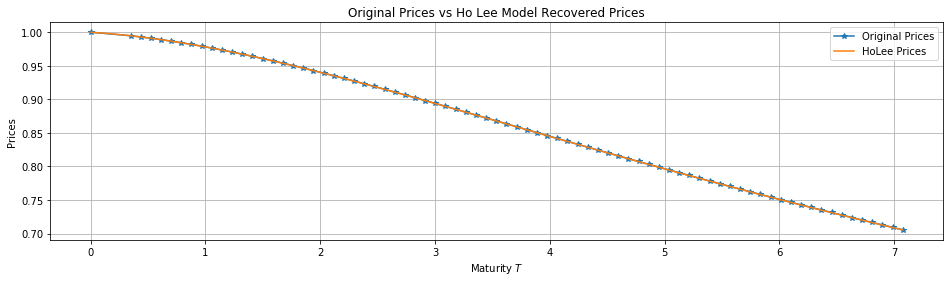

In [15]:
plt.figure(figsize=(16,4))

plt.plot(Maturities, Prices, marker='*', label = "Original Prices")
plt.plot(Timeline, LoheePrices, label ='HoLee Prices')

plt.xlabel(r'Maturity $T$ ')
plt.title(r'Original Prices vs Ho Lee Model Recovered Prices')
plt.grid(True)
plt.legend()
plt.ylabel('Prices')

plt.show()


### Now we simulate the short term rate with Ho-Lee sde and price zero coupon bonds

We aim to recover the same prices we used as input  

Let's run the first check on the ZCB with a 5 yr maturity

In [16]:
# So we always use the same random numbers
npr.seed(1500)

In [17]:
tau = 5
I   = 10000     # no. of simulations
M   = tau * 252   # trading day per annum

In [18]:
# run the sde
lohee.Euler(M, I, tau)
vals = lohee.StochasticPrice(lohee.rates, lohee.times)

In [20]:
print("the price is:      ", vals[0])
print("the price +2sd is :", vals[1])
print("the price -2sd is :", vals[2])
print("the Analytic price is :", lohee.Exact_zcb(0, 5))

the price is:       0.7943654623190287
the price +2sd is : 0.7964858073755943
the price -2sd is : 0.7922451172624632
the Analytic price is : 0.7964667869423302


All fine! We are ready to run simuations and price all our input ZCBs  

In [21]:
# So we always use the same random numbers
npr.seed(1500)

size   = (Prices.shape[0])
Result = np.zeros((size, 6))
for i, j in enumerate(Maturities):
    tau = j
    M   = tau * 252
    lohee.Euler(M, I, tau)
    vals = lohee.StochasticPrice(lohee.rates, lohee.times)
    Result[i,0] = np.round(j,5)
    Result[i,1] = np.round(vals[0],4)
    Result[i,2] = np.round(vals[1],4)
    Result[i,3] = np.round(Prices[i],4)
    Result[i,4] = np.round(lohee.Exact_zcb(0,j),4)
    Result[i,5] = np.round(vals[2],4)

see the results

In [22]:
Result = pd.DataFrame(Result)
Result.columns = ['Maturity','MC Price','MC Price+2CD', 'Original Price', 'LoHee Price', 'MC Price-2CD',]
Result

,Maturity,MC Price,MC Price+2CD,Original Price,LoHee Price,MC Price-2CD
0,0.00397,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.34795,0.9948,0.9948,0.9948,0.9947,0.9947
2,0.43645,0.9931,0.9932,0.9930,0.9930,0.9931
3,0.52495,0.9911,0.9912,0.9911,0.9910,0.9910
4,0.61345,0.9889,0.9891,0.9890,0.9889,0.9888
5,0.70195,0.9868,0.9870,0.9867,0.9867,0.9867
6,0.79045,0.9843,0.9845,0.9843,0.9843,0.9842
7,0.87895,0.9818,0.9820,0.9818,0.9818,0.9816
8,0.96746,0.9792,0.9794,0.9792,0.9791,0.9790
9,1.05596,0.9765,0.9768,0.9764,0.9763,0.9763


### Let's find the one year forward price of a ZCB maturing in 5 years

We exploit the formula $Y(t,t+\tau) = -\frac{A(t,t+\tau)}{\tau} + r_t$ in the introduction to recover the price of the ZCB with a 5 year to maturity. 

The idea is to simulate $dr(t)$ for one year and use the formula above to value the ZCB which has now a four year to maturity. 

In [23]:
# So we always use the same random numbers
npr.seed(1500)

I   = 10000     # no. of simulations
T_O = 1 # 1 year
T_M = 5 # 5 year
M   = T_O * 252 # trading day per annum
    
BondValue = ZCBValue(0) # an instance of class ZCBValue, to model the payoff value at year 1    
vals = lohee.FutureZCB(M,I, T_O, T_M, BondValue)

In [24]:
print( "----------------------------------------------------------------")
print("the MC price of a ZCB maturing in",T_M, "years is:", np.round(vals[0],4))
print("The ZCB price from Formulae is               ", np.round(lohee.Exact_zcb(0, 5),4))

print( "----------------------------------------------------------------")
print("the MC price +2sd is :", vals[1])
print("the MC price -2sd is :", vals[2])
print( "----------------------------------------------------------------")

print("the MC price of a ZCB maturing in",T_O, "year is:", np.round(vals[4],4))
print("The ZCB price from Formulae is              ", np.round(lohee.Exact_zcb(0, 1),4))

print( "----------------------------------------------------------------")
print("The MC Expected short term rate in",T_O,"year is ", np.round(vals[5],4))
print("The Expected short term rate in",T_O,"year is    ", np.round(lohee.ExpectedRate(0,1),4))
print( "----------------------------------------------------------------")
print("the Price in",T_O,"year of a ZCB price maturing in",T_M,"years is", np.round(vals[3],4))
print("The fwd price from Formulae is                           ", np.round(lohee.Exact_zcb(0, 5)/lohee.Exact_zcb(0, 1),4))

----------------------------------------------------------------
the MC price of a ZCB maturing in 5 years is: 0.7966
The ZCB price from Formulae is                0.7965
----------------------------------------------------------------
the MC price +2sd is : 0.7980795355791994
the MC price -2sd is : 0.7951486057931083
----------------------------------------------------------------
the MC price of a ZCB maturing in 1 year is: 0.9782
The ZCB price from Formulae is               0.9781
----------------------------------------------------------------
The MC Expected short term rate in 1 year is  0.0321
The Expected short term rate in 1 year is     0.0322
----------------------------------------------------------------
the Price in 1 year of a ZCB price maturing in 5 years is 0.8137
The fwd price from Formulae is                            0.8143


### Let's price an option maturing in one year, on a zero coupon bond maturing in 5 years 

The idea is to simulate $dr(t)$ for one year, until the option matures, and use the same formula used previously to value the ZCB which has now a four year to maturity. Once we know the ZCB value, we can calculate the option payoff, and consequenttly discount it back using the simulated rates paths. 

We check the simulated result with the Analytic price 

In [25]:
# So we always use the same random numbers
npr.seed(1500)

I   = 10000     # no. of simulations
OptionStrike = 0.8
BondValue    = ZCBOption(OptionStrike) # an instance of class ZCBOption, to model the payoff value at year 1    

In [26]:
vals         = lohee.FutureZCB(M,I, T_O, T_M, BondValue)

In [27]:
print( "------------------------------------------------------")
print("the MC price of an one year Option on a ZCB maturing in:",T_M, "years is:", np.round(vals[0],4))

print( "------------------------------------------------------")
print("the MC price +1.96sd is :", vals[1])
print("the MC price -1.96sd is :", vals[2])

print("The Analytic Lo Hee Price is ", 0.03405) # Lo Hee Analytic Option model is not included

------------------------------------------------------
the MC price of an one year Option on a ZCB maturing in: 5 years is: 0.0337
------------------------------------------------------
the MC price +1.96sd is : 0.034566710876962996
the MC price -1.96sd is : 0.03277160775377575
The Analytic Lo Hee Price is  0.03405
